In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import glob
import os
import cv2
import torch
from tqdm import tqdm

In [2]:
out_dir = 'out/'
arch = 'resnet18/'
out_arch = out_dir + arch
directories = {
    'average': out_arch + 'average/',
    'deepmil_multi': out_arch + 'deepmil_multi/',
    'gradcampp': out_arch + 'gradcampp/',
    'gradcam': out_arch + 'gradcam/',
    'lse': out_arch + 'lse/',
    'max': out_arch + 'max/',
    'wildcat': out_arch + 'wildcat/',
    'ablation': out_arch + 'ablation/'
}

In [3]:
def get_overlays_and_dice(path):
    paths = glob.glob(path + '*.pkl')
    
    overlays = None
    dices = None
    
    objects = {}
    for p in paths:
        with open(p, 'rb') as f:
            pickle_obj = pickle.load(f)
            base = os.path.basename(p)
            key = os.path.splitext(base)[0]
            objects[key] = pickle_obj
                
    return objects

In [4]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap / (255.0)
#     b, g, r = heatmap.split(1)
#     heatmap = torch.cat([r, g, b])

    result = heatmap + img
#     result = result.div(result.max()).squeeze()

    return heatmap, result

In [5]:
results = {method: get_overlays_and_dice(directory) for (method, directory) in zip(directories.keys(), directories.values())}

In [6]:
# Input and GT
with open('npy_results/overlay_gt/input.pkl', 'rb') as f:
    img_input = pickle.load(f)
    img_input = [item.squeeze().transpose(1, 2, 0) for item in img_input]
with open('npy_results/overlay_gt/gt_overlays.pkl', 'rb') as f:
    gt_overlay = pickle.load(f)
    gt_overlay = [item.transpose(1, 2, 0) for item in gt_overlay]

In [7]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min)

In [8]:
norm_cam = normalize(results['average']['cams'][0])
norm_cam[0].max(), norm_cam[1].max()

(1.0, 0.5470782)

In [9]:
results['gradcam']['cams'][36][0].shape

(522, 775)

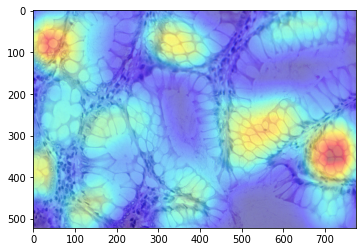

In [10]:
heatmap, result = visualize_cam(results['gradcam']['cams'][0][0], img_input[0])
plt.imshow(img_input[0])
plt.imshow(normalize(results['gradcam']['cams'][0][0]) * 255, alpha=0.5, cmap='jet')

In [11]:
fig_dir = 'result_figs/' + arch
os.makedirs(fig_dir, exist_ok=True)
for i in tqdm(range(len(img_input)), ncols=80, desc='Saving figures'):    
    fig, axs = plt.subplots(1, len(results.keys()) * 2 + 2, sharey='row', gridspec_kw={'wspace': 0.01}, figsize=(50,5))
    (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17) = axs
    
    result_axes = [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17]
    sub_ax_count = 0
    for method in results.keys():
        cams, dice, label = results[method]['cams'][i], results[method]['dice_per_image'][i], results[method]['labels'][i]
        norm_cams = normalize(cams)
        ax_0, ax_1 = result_axes[sub_ax_count], result_axes[sub_ax_count + 1]
        
        ax_0.imshow(img_input[i])
        ax_0.imshow(255 * cams[0], alpha=0.6, cmap='jet')
        ax_0.set_title('{} benign'.format(method))
        ax_0.axis('off')
        
        ax_1.imshow(img_input[i])
        ax_1.imshow(255 * cams[1], alpha=0.6, cmap='jet')
        ax_1.set_title('{} malign'.format(method))
        ax_1.axis('off')
        
        sub_ax_count = sub_ax_count + 2
        
    ax0.imshow(img_input[i])
    ax0.set_title('Input: {}'.format('benign' if label == 0 else 'malign'))
    ax0.axis('off')
    
    ax1.imshow(gt_overlay[i])
    ax1.set_title('GT overlay')
    ax1.axis('off')
    
    f_name = 'results_{}.png'.format(i)
    f_path = os.path.join(fig_dir, f_name)
    plt.savefig(f_path, dpi=150)
    plt.close(fig)

Saving figures: 100%|███████████████████████████| 80/80 [04:47<00:00,  3.60s/it]
